# Prepare data

In [5]:
# Import Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

from hpsklearn import HyperoptEstimator

In [6]:
pheme = pd.read_csv('datasets\pheme.csv')
politifact = pd.read_csv('datasets\politifact.csv')
twitter = pd.read_csv('datasets\\twitter.csv')

In [11]:
# glove general
import spacy

nlp = spacy.load("en_core_web_lg")

t = nlp(pheme['text'][0]).vector

X = np.array([nlp(text).vector for text in pheme['text']])
print(X.shape)

(2402, 300)


In [39]:
# glove twitter

nlp = spacy.load("spacy-twitter")
X = np.array([nlp(text).vector for text in pheme['text']])
print(X.shape)

#maybe try gensim? or stick with glove idk

(2402, 200)


In [82]:
nlp = spacy.load("spacy-twitter")


def embed_two_datasets(set1, set2):
    nlp = spacy.load("spacy-twitter")
    all_statements = np.append(set1, set2)
    all_tf = np.array([nlp(text).vector for text in all_statements])
    return all_tf[:len(set1)], all_tf[len(set1):]

X_train, X_test = embed_two_datasets(pheme['text'], twitter['text'])
y_train  = pheme['target']
y_test = twitter['verdict']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, pheme['target'], test_size = 0.25, random_state = 42)

In [83]:
X_test.shape

(1729, 200)

In [84]:
X_train[0]

array([-1.38609275e-01,  1.89999361e-02, -7.50796720e-02,  2.48308275e-02,
       -1.39685705e-01, -2.34315351e-01,  1.47768661e-01, -5.72067760e-02,
        3.36821228e-02, -2.05100417e-01,  1.05857767e-01, -3.87459807e-02,
       -6.21646702e-01,  1.88650806e-02,  1.03190921e-01, -2.15060294e-01,
        1.39928550e-01, -4.50162552e-02,  3.04362923e-02, -7.88250044e-02,
       -1.67214740e-02,  7.73217604e-02, -9.32632908e-02, -1.58649474e-01,
        1.71208397e-01,  6.43799841e-01,  1.43018797e-01, -1.90447912e-01,
        4.88574989e-02,  3.15194088e-03,  5.55119179e-02,  2.71153301e-02,
       -8.74384269e-02, -2.81514972e-01,  8.36100504e-02,  2.22462844e-02,
        4.28482555e-02,  2.41334978e-02,  2.48224899e-01, -5.70230335e-02,
        2.86812723e-01, -6.86224625e-02,  3.45940590e-02,  9.31318700e-02,
       -5.74019663e-02,  1.46082088e-01, -2.14937534e-02, -2.95173507e-02,
       -5.83601184e-02, -2.19749063e-02, -1.21514320e-01, -1.82792600e-02,
       -4.44278717e-02,  

In [5]:
def encode_two_datasets(set1, set2):
    tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
    all_statements = np.append(set1, set2)
    all_tf = tfidf.fit_transform(all_statements)
    return all_tf[:len(set1)], all_tf[len(set1):]

In [8]:
# DO NOT RUN THIS BLOCK UNLESS YOU WANT TO USE TFIDF ENCODING

rs = 42
method = 3
tfidf = TfidfVectorizer(max_df=0.6, min_df=0)
#tfidf = CountVectorizer(max_df=0.6, min_df=0)

if method == 0:
    pheme_tf = tfidf.fit_transform(pheme['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(pheme_tf, pheme['target'], test_size = 0.25, random_state = rs)
elif method == 1:
    polit_tf = tfidf.fit_transform(politifact['statement'].values)
    X_train, X_test, y_train, y_test = train_test_split(polit_tf, politifact['verdict'], test_size = 0.25, random_state = rs)
elif method == 2:
    twitter_tf = tfidf.fit_transform(twitter['text'].values)
    X_train, X_test, y_train, y_test = train_test_split(twitter_tf, twitter['verdict'], test_size = 0.25, random_state = rs)
elif method == 3:
    X_train, X_test = encode_two_datasets(twitter['text'].values, pheme['text'].values)
    y_test = pheme['target']
    y_train = twitter['verdict']
else:
    X_train, X_test = encode_two_datasets(politifact['statement'].values, pheme['text'].values)
    y_train = politifact['verdict']
    y_test = pheme['target']
    

# Set no. of folds
num_folds = 10

###Things to do: add more features
print(X_train.shape)

(1729, 6101)


# Run models

In [7]:
# Model running function
def run_model_after_gridsearch(best_estimators, X_train, y_train, X_test, y_test):
    mod = best_estimators
    mod.fit(X_train, y_train)
    pred_y = mod.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show()  

In [8]:
def run_model_manually(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 

In [85]:
def optimize_model(model, X_train, y_train):
    mod = HyperoptEstimator(classifier=model,
                            preprocessing=[],
                            max_evals=50)
    mod.fit(X_train, y_train)
    print(mod.best_model())
    return mod

def evaluate_model(model, X_test, y_test):
    pred_y = model.predict(X_test)
    acc_mod = accuracy_score(y_test, pred_y)
    print("Accuracy:", float("{0:.2f}".format(acc_mod*100)), "%")
    f1_mod = f1_score(y_test, pred_y, average="macro")
    print("F1:", float("{0:.2f}".format(f1_mod*100)), "%")
    cm = confusion_matrix(y_test, pred_y)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["true", "false"])
    disp.plot()
    plt.show() 
    

In [86]:
# SVM
from hpsklearn import svc 
svm = optimize_model(svc("mySVC", probability=True), X_train, y_train)

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:01<00:00,  1.87s/trial, best loss: 0.6112266112266111]
{'learner': SVC(C=1.077230887013171, coef0=0.22621806544157008,
    decision_function_shape='ovo', kernel='sigmoid', probability=True,
    random_state=3, tol=0.00301310621491405), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 54.48 %
F1: 50.54 %


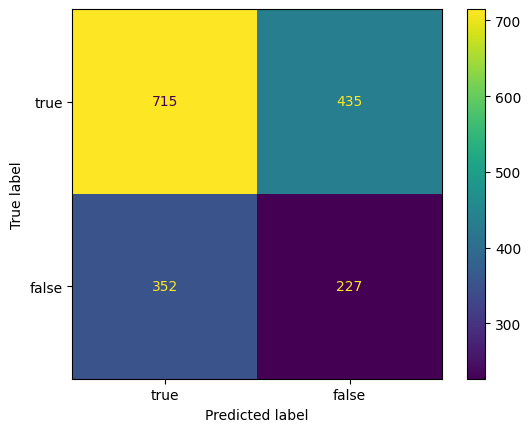

In [87]:
evaluate_model(svm, X_test, y_test)

In [88]:
# KNN
from hpsklearn import k_neighbors_classifier
from hyperopt import hp
knn_metrics = hp.choice("metric", {'cityblock', 'l1', 'l2', 'euclidean', 'manhattan'})
knn= optimize_model(k_neighbors_classifier("myKNN"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.13s/trial, best loss: 0.5405405405405406]
{'learner': KNeighborsClassifier(algorithm='brute', leaf_size=34, n_jobs=1, n_neighbors=2,
                     p=1.191732944368408, weights='distance'), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 66.74 %
F1: 63.03 %


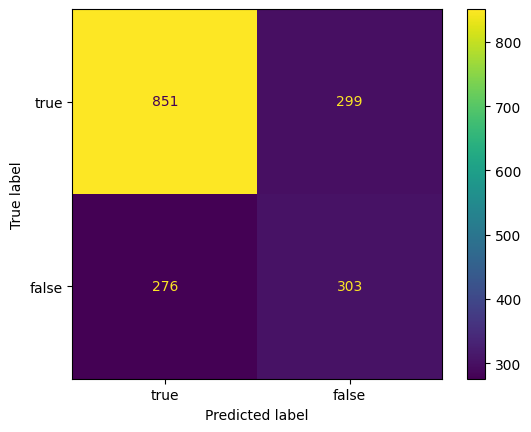

In [89]:
evaluate_model(knn, X_test, y_test)

In [90]:
# Logistic Regression logistic_regression
from hpsklearn import logistic_regression
myLR = optimize_model(logistic_regression("myLR"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.19s/trial, best loss: 0.661122661122661]
{'learner': LogisticRegression(C=1.3659411682130187, max_iter=686, n_jobs=1, random_state=3,
                   tol=4.5563069427718224e-05), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 65.24 %
F1: 62.01 %


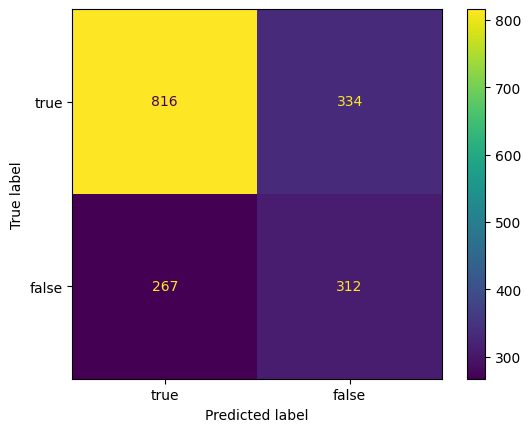

In [91]:
evaluate_model(myLR, X_test, y_test)

In [92]:
# AdaBoost
from hpsklearn import ada_boost_classifier, decision_tree_classifier
baseDT = decision_tree_classifier("adaDT")
ada = optimize_model(ada_boost_classifier("myada", base_estimator=baseDT), X_train, y_train)

 97%|█████████▋| 37/38 [01:11<?, ?trial/s, best loss=?]
{'learner': AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_features=0.4975261133367105,
                                                         random_state=0,
                                                         splitter='random'),
                   learning_rate=0.03126043406672697, n_estimators=12,
                   random_state=4), 'preprocs': (), 'ex_preprocs': ()}


Accuracy: 60.38 %
F1: 59.03 %


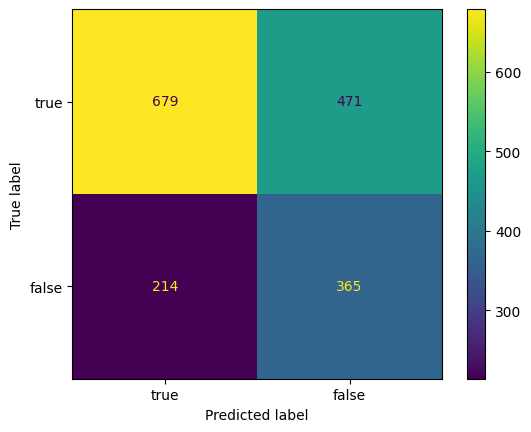

In [ ]:
# Run model with best results
evaluate_model(ada, X_test, y_test)

In [ ]:
from hpsklearn import mlp_classifier

mlp = optimize_model(mlp_classifier("mlp"), X_train, y_train)

100%|██████████| 50/50 [00:01<00:00,  1.82s/trial, best loss: 0.43866943866943864]
{'learner': MLPClassifier(activation='tanh', alpha=0.0026887154721275002,
              beta_1=0.8553770116307531, beta_2=0.9804899121343321,
              epsilon=9.429165401584914e-06, learning_rate='invscaling',
              learning_rate_init=0.013721599229091956, max_fun=29777,
              max_iter=236, momentum=0.9752440705625979, n_iter_no_change=30,
              power_t=0.1201431258787026, random_state=1,
              tol=0.0015920491801800726,
              validation_fraction=0.13021436182820345), 'preprocs': (), 'ex_preprocs': ()}


c:\Users\willc\miniconda3\envs\rumour-ensemble\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (236) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Accuracy: 65.64 %
F1: 63.35 %


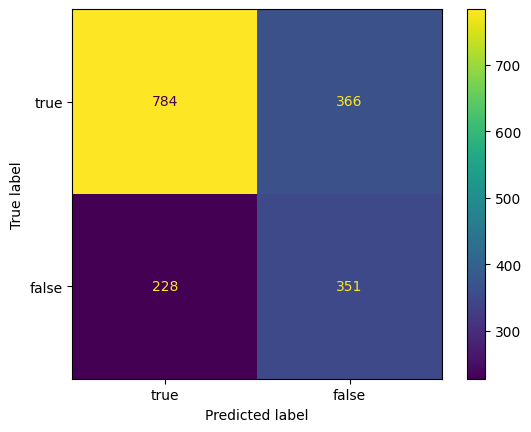

In [ ]:
evaluate_model(mlp, X_test, y_test)

# Clustering

In [94]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture().fit(X_train)
gm.means_.shape



(1, 200)

## Ensemble

In [ ]:
sk_svm = svm.best_model()['learner']
sk_knn = knn.best_model()['learner']
sk_LR = myLR.best_model()['learner']
sk_ada = ada.best_model()['learner']
sk_mlp = mlp.best_model()['learner']

c:\Users\willc\miniconda3\envs\rumour-ensemble\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (236) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Accuracy: 68.54 %
F1: 65.07 %


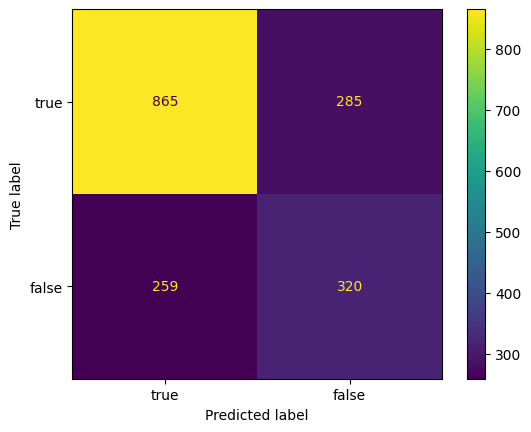

In [ ]:
# Hard voting
from sklearn.ensemble import VotingClassifier

sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]
names = ["svm", "LR", "ada", "mlp", "knn"]

hardvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="hard")
hardvoter.fit(X_train, y_train)
evaluate_model(hardvoter, X_test, y_test)

c:\Users\willc\miniconda3\envs\rumour-ensemble\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (236) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Accuracy: 68.71 %
F1: 65.19 %


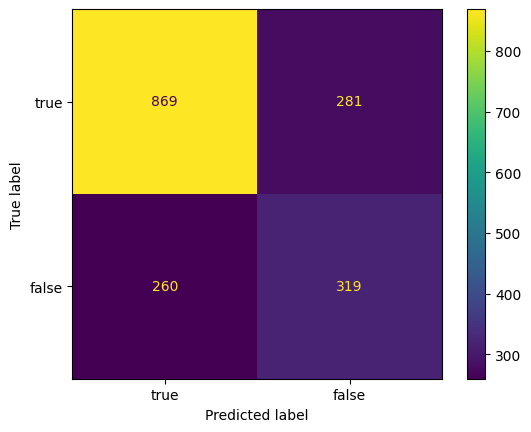

In [ ]:
softvoter = VotingClassifier(estimators=list(zip(names, sk_classifiers)), voting="soft")
softvoter.fit(X_train, y_train)
evaluate_model(softvoter, X_test, y_test)

Accuracy: 69.17 %
F1: 65.73 %


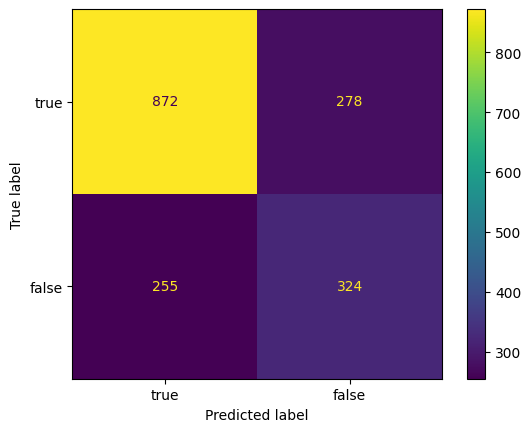

In [ ]:
from deslib.des import KNORAE
sk_classifiers = [sk_svm, sk_LR, sk_ada, sk_mlp, sk_knn]
names = ["svm", "LR", "ada", "mlp", "knn"]
ensemble = KNORAE(pool_classifiers=sk_classifiers)

ensemble.fit(X_train, y_train)
evaluate_model(ensemble, X_test, y_test)

Accuracy: 68.71 %
F1: 65.24 %


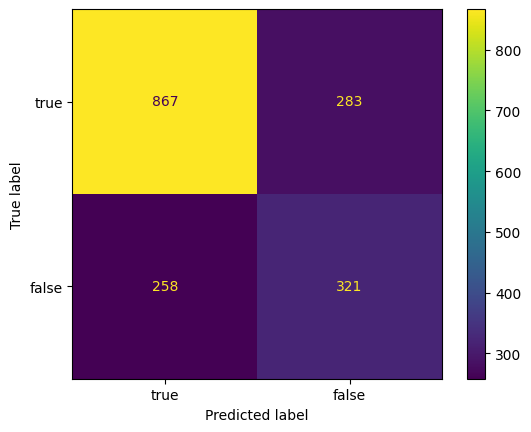

In [ ]:
from deslib.des import KNORAU

ensemble = KNORAU(pool_classifiers=sk_classifiers)

ensemble.fit(X_train, y_train)
evaluate_model(ensemble, X_test, y_test)